<a href="https://colab.research.google.com/github/AntoineChapel/GAN_WGAN_project/blob/main/WGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from IPython import display

%matplotlib inline

In [5]:
data = pd.read_csv(r"https://raw.githubusercontent.com/AntoineChapel/GAN_WGAN_project/main/cat_data_small.csv")

In [31]:
def make_generator_model():
    model = tf.keras.Sequential()
    
    model.add(keras.layers.Dense(8*8*1024, use_bias=False, input_shape=(100,)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Reshape((8, 8, 1024)))
    
    model.add(keras.layers.Conv2DTranspose(256, (12, 12), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 256)
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2DTranspose(64, (12, 12), strides=(2, 2), padding='same', use_bias=False))    
    assert model.output_shape == (None, 16, 16, 64)
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    
    model.add(keras.layers.Conv2DTranspose(1, (12, 12), strides=(4, 4), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 1)
    
    return model

In [32]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

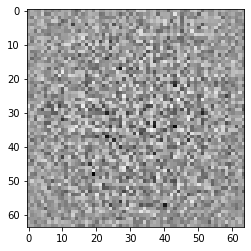

In [33]:
plt.imshow(generated_image[0, :, :, 0], cmap='Greys_r')

In [34]:
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 65536)             6553600   
                                                                 
 batch_normalization_3 (Batc  (None, 65536)            262144    
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 65536)             0         
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 1024)        0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 8, 8, 256)        37748736  
 ranspose)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 8, 8, 256)       

In [35]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 1]))
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1))

    return model

In [36]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00049858]], shape=(1, 1), dtype=float32)


In [37]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [38]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [39]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [40]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [41]:
@tf.function #causes the function to be compiled (speeds up its execution)
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True) #generates a fake image

        real_output = discriminator(images, training=True)              #applies the classifier to real images
        fake_output = discriminator(generated_images, training=True)    #applies the classifier to fake images

        gen_loss = generator_loss(fake_output)                          #computes the loss of the generator: "how well did it fool the discriminator"
        disc_loss = discriminator_loss(real_output, fake_output)        #computes the loss of the discriminator: "how bad did it mistake in separating real from fake images"

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)            #takes a numerical derivative of the generator loss function wrt its weights
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)  #takes a numerical derivative of the discriminator loss function wrt its weights

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))             #updates generator gradients
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables)) #updates discriminator gradients

In [42]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(15, 15))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='Greys_r')
        plt.axis('off')
    plt.show()

In [43]:
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)
        print(epoch)
  # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [44]:
EPOCHS = 5000
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [45]:
n_images = 32

data_np = data.to_numpy()[:n_images, 1:]
train_images = data_np.reshape(n_images, 64, 64, 1)
BUFFER_SIZE = 60000
BATCH_SIZE = 8
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

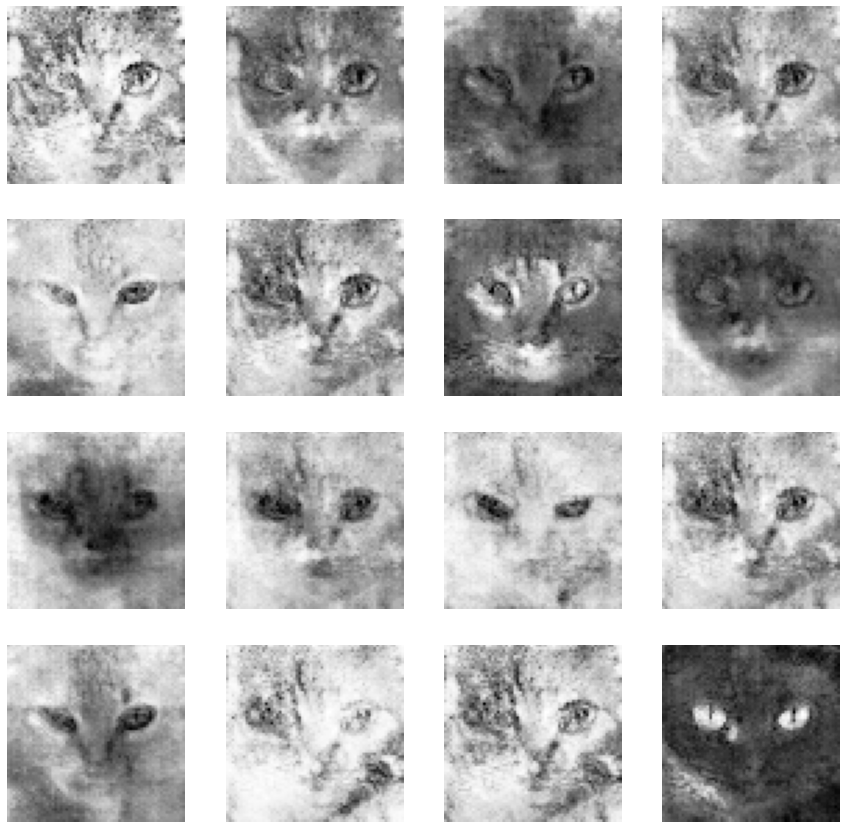

In [46]:
train(train_dataset, EPOCHS)

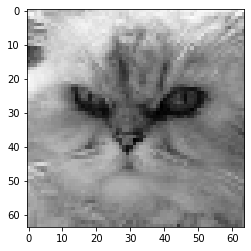

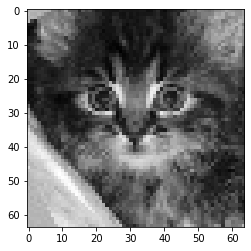

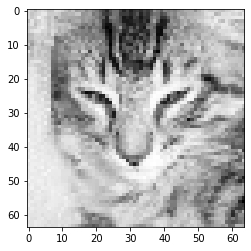

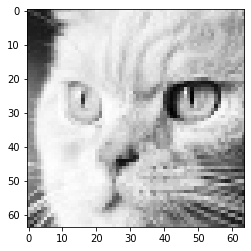

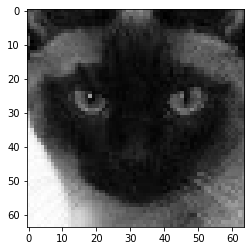

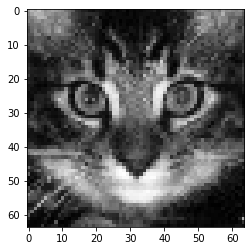

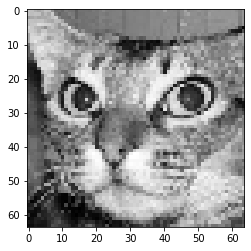

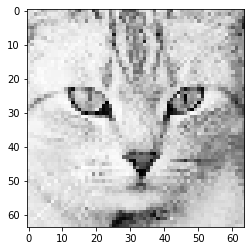

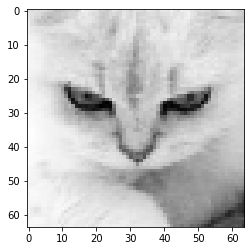

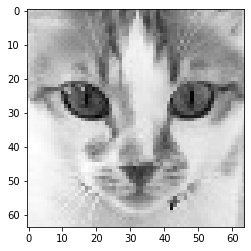

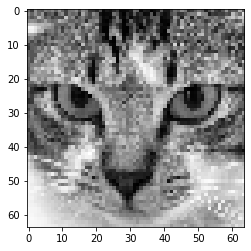

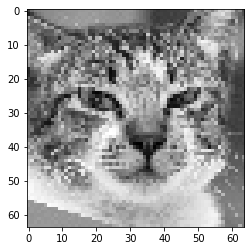

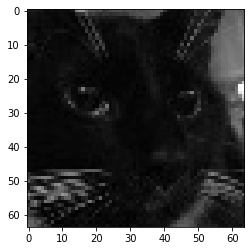

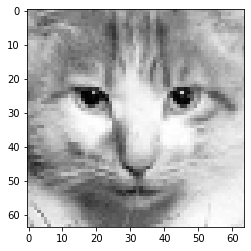

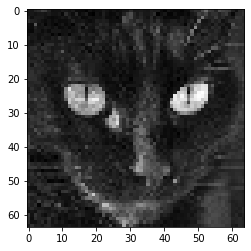

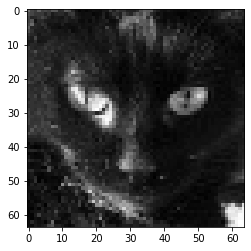

In [30]:
for i in range(16):
    plt.imshow(data_np[i, :].reshape(64, 64), cmap='Greys_r')
    plt.show()